# Polarized and nonpolarized Twitter networks from the 2019 Finnish Parliamentary Elections

This dataset includes 183 Twitter retweet networks collected during the 2019 Finnish Parliamentary Elections.

The first 150 networks are built around single hashtags, such as #police, #nature, and #immigration. The remaining 33 networks are constructed using a combination of hashtags focused on specific topics like climate change and economic policy.

Each filename consists of two parts: the first part indicates whether the network is based on a single hashtag (in lowercase) or a set of hashtags (in uppercase). The second part represents the tweet period.

    "p1" corresponds to the pre-election period (March 1 to April 14).

    "p2" corresponds to the inter-election period (April 15 to May 26).

    "p3" corresponds to the post-election period (May 27 to July 31).

The nodes in the networks represent anonymized Twitter accounts, and directed ties indicate retweet endorsements on specific topics. Each file contains three columns: retweeter, retweeted, and weight.

Please see the references for more details.

Network labels, whether they are labeled as controversial, and whether they are based on single or multiple hashtags, can be found in the "networks_info.csv" file.

In [1]:
import pathlib
import polars as pl
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import norm

# Methods to calculate svd
from numpy.linalg import svd
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import randomized_svd

In [2]:
DATA_PATH = "../data/TwitterNetworks/"
DATA_FILES = sorted(pathlib.Path(DATA_PATH).glob("*.edgelist"))


def load_graphs(data_files, filter_phrase=None):
    graphs = {}
    for file in data_files:
        if filter_phrase is None or filter_phrase in file.name:
            # Read CSV file with pandas
            df = pd.read_csv(file)
            # Create directed graph from edge list with weights
            graph = nx.from_pandas_edgelist(
                df,
                source='retweeter',
                target='retweeted',
                edge_attr='weight',
                create_using=nx.DiGraph() # type: ignore
            ) # type: ignore
            
            # All weights should be 1
            nx.set_edge_attributes(graph, 1, "weight") # type: ignore
            
            graphs[file.stem] = graph
    return graphs

graphs = load_graphs(DATA_FILES, filter_phrase="CENTRE")
graphs

{'CENTRE_p1': <networkx.classes.digraph.DiGraph at 0x7fcd499ab410>,
 'CENTRE_p2': <networkx.classes.digraph.DiGraph at 0x7fcd48bf55e0>,
 'CENTRE_p3': <networkx.classes.digraph.DiGraph at 0x7fcd566e23f0>}

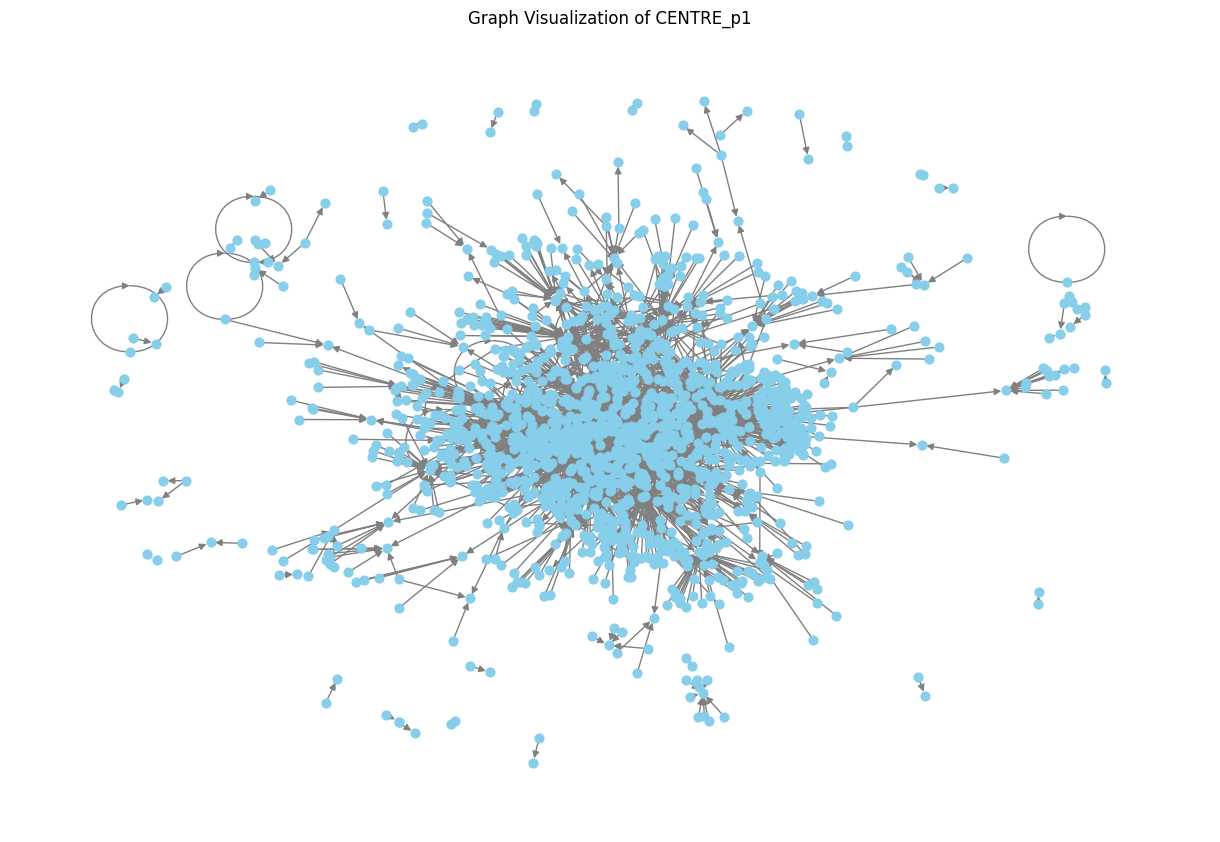

Number of nodes: 1600
Number of edges: 2887


In [3]:
graph_index = 0
graph = list(graphs.values())[graph_index]
title = list(graphs.keys())[graph_index]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(graph, k=6, seed=32)
nx.draw(graph, pos, with_labels=False, node_size=40, arrowsize=10, node_color='skyblue', edge_color='gray')
plt.title(f"Graph Visualization of {title}")
plt.show()

print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")

In [3]:
# Computes the full SVD of matrix A and returns the top k singular values.
from functools import partial

try:
    from joblib import Parallel, delayed  # type: ignore
    _HAVE_JOBLIB = True
except Exception:
    _HAVE_JOBLIB = False


def truncated_svd(A, k=None):
    S = svd(A, compute_uv=False, full_matrices=False)
    if k is None:
        k = len(S)
    S_k = S[:k]
    return S_k


# Helper to compute the log-likelihood for a given split q
# Defined at top-level so it's picklable by process-based executors
def _compute_ll_for_q(sv: np.ndarray, p: int, q: int) -> tuple[int, float]:
    q = int(q)
    S1 = sv[:q]
    S2 = sv[q:]

    # Basic validity checks matching the original logic
    if len(S2) == 0 or p <= 2:
        return (q, float(-np.inf))

    mu1 = np.mean(S1) if len(S1) else 0.0
    mu2 = np.mean(S2) if len(S2) else 0.0

    if len(S1) > 1:
        s1_squared = np.var(S1, ddof=1)
    else:
        s1_squared = 0.0

    if len(S2) > 1:
        s2_squared = np.var(S2, ddof=1)
    else:
        s2_squared = 0.0

    sigma2 = ((q - 1) * s1_squared + (p - q - 1) * s2_squared) / (p - 2)
    if not np.isfinite(sigma2) or sigma2 <= 0:
        return (q, float(-np.inf))

    sigma = np.sqrt(sigma2)

    # Vectorized log-likelihood
    ll = 0.0
    if len(S1):
        ll += float(np.sum(norm.logpdf(S1, mu1, sigma)))
    if len(S2):
        ll += float(np.sum(norm.logpdf(S2, mu2, sigma)))

    return (q, ll)


# Estimate the embedding dimension using a likelihood-based method
# Parallelized across candidate splits q with optional n_jobs

def embedding_dimension(singular_values, k=None, n_jobs: int = -1):
    
    if k is None:
        k = len(singular_values)

    sv = np.array(singular_values[:k], dtype=float)
    p = len(sv)

    # Maintain original behavior for small p
    if p <= 2:
        return 1

    qs = list(range(1, p))

    # Sequential path (reproducible and minimal overhead)
    if n_jobs == 1:
        best_ll = float(-np.inf)
        d_hat = 1
        for q in qs:
            _, ll = _compute_ll_for_q(sv, p, q)
            if ll > best_ll:
                best_ll = ll
                d_hat = q
        return d_hat

    # Parallel path: prefer joblib when available, else fallback to stdlib
    if _HAVE_JOBLIB:
        results = Parallel(n_jobs=n_jobs, backend="loky")(
            delayed(_compute_ll_for_q)(sv, p, q) for q in qs
        )
    else:
        import concurrent.futures as cf

        max_workers = None if n_jobs in (None, -1) else int(n_jobs)
        func = partial(_compute_ll_for_q, sv, p)
        with cf.ProcessPoolExecutor(max_workers=max_workers) as ex:
            results = list(ex.map(func, qs))

    # Pick q with the highest log-likelihood
    if not results:
        return 1

    best_q, _best_ll = max(results, key=lambda t: t[1]) # type: ignore
    return int(best_q)

In [5]:
# Measure polarization of all loaded graphs

print(f"Total graphs loaded: {len(graphs)}")
print(f"Graph names: {list(graphs.keys())}\n")

for graph_name, graph in graphs.items():
    print(f"Graph: {graph_name}")
    print(f"  Nodes: {graph.number_of_nodes()}, Edges: {graph.number_of_edges()}")
    A = nx.to_numpy_array(graph)
    singular_values = truncated_svd(A)
    d_hat = embedding_dimension(singular_values)
    print(f"  Estimated embedding dimension (d̂): {d_hat}\n")

Total graphs loaded: 3
Graph names: ['CENTRE_p1', 'CENTRE_p2', 'CENTRE_p3']

Graph: CENTRE_p1
  Nodes: 1600, Edges: 2887
  Estimated embedding dimension (d̂): 100

Graph: CENTRE_p2
  Nodes: 1488, Edges: 2206
  Estimated embedding dimension (d̂): 93

Graph: CENTRE_p3
  Nodes: 1030, Edges: 1727
  Estimated embedding dimension (d̂): 81



In [6]:
# Measure polarization of all loaded graphs that contain "digitalisaatio" in the name

graph = load_graphs(DATA_FILES, filter_phrase="digitalisaatio")

for graph_name, graph in graph.items():
    print(f"Graph: {graph_name}")
    print(f"  Nodes: {graph.number_of_nodes()}, Edges: {graph.number_of_edges()}")
    A = nx.to_numpy_array(graph)
    singular_values = truncated_svd(A)
    d_hat = embedding_dimension(singular_values)
    print(f"  Estimated embedding dimension (d̂): {d_hat}\n")

Graph: digitalisaatio_p1
  Nodes: 1687, Edges: 1807
  Estimated embedding dimension (d̂): 259

Graph: digitalisaatio_p2
  Nodes: 1279, Edges: 1269
  Estimated embedding dimension (d̂): 213

Graph: digitalisaatio_p3
  Nodes: 1445, Edges: 1515
  Estimated embedding dimension (d̂): 231



In [38]:
# Relate unique names to previously loaded graphS
# A unique name may correspond to multiple graphs if p1, p2, p3 variants exist
# Read all file names in the DATA_PATH directory and get the unique names of the edgelist files
# Use the DATA_FILES variable defined at the beginning of the script
# Remove the p1, p2, or p3 from the file names

unique_names = set()
for file in DATA_FILES:
    match = re.match(r"(.*?)(?:_p[123])?\.edgelist", file.name)
    if match:
        unique_names.add(match.group(1))

name_variants = {name: [] for name in unique_names}
for file in DATA_FILES:
    name_variant = file.stem.split('_')
    name_variants[name_variant[0]].append(name_variant[1])   
        
name_variants

{'arvopohja': ['p2'],
 'liikenne': ['p1', 'p2', 'p3'],
 'GREEN': ['p1', 'p2', 'p3'],
 'IMMIGRATION': ['p1', 'p2', 'p3'],
 'turvallisuus': ['p1', 'p2', 'p3'],
 'keskusta': ['p1', 'p2', 'p3'],
 'turpo': ['p1', 'p2', 'p3'],
 'nuoret': ['p1', 'p2', 'p3'],
 'CENTRE': ['p1', 'p2', 'p3'],
 'digitalisaatio': ['p1', 'p2', 'p3'],
 'sak': ['p1', 'p2', 'p3'],
 'metsä': ['p2', 'p3'],
 'vaalit': ['p1', 'p2'],
 'suomi': ['p1', 'p2', 'p3'],
 'terrorismi': ['p3'],
 'opiskelijat': ['p3'],
 'siksitiede': ['p1'],
 'eduskunta': ['p2', 'p3'],
 'sananvapaus': ['p2', 'p3'],
 'FINNS': ['p1', 'p2', 'p3'],
 'eduskuntavaalit': ['p1'],
 'poliisi': ['p1', 'p2', 'p3'],
 'perussuomalaiset': ['p1', 'p2', 'p3'],
 'ilmasto': ['p1', 'p2', 'p3'],
 'ECONOMICPOLICY': ['p1', 'p2', 'p3'],
 'ympäristö': ['p3'],
 'koulutuslupaus': ['p1'],
 'mielenterveys': ['p1', 'p2', 'p3'],
 'SOCIALSECURITY': ['p1', 'p2', 'p3'],
 'työelämä': ['p1', 'p2', 'p3'],
 'CLIMATE': ['p1', 'p2', 'p3'],
 'hyvinvointi': ['p1', 'p2', 'p3'],
 'NATIONAL': [

In [ ]:
def summarize_graphs(name_variants):
    # Add column controversial and single hastag to the summarize_graphs function
    # Import network_info.csv
    network_info = pd.read_csv("../data/TwitterNetworks/network_info.csv")
    graphs_summary = []
    for name, variants in name_variants.items():
        # With the graph name and variant and get controversial and single_hashtag from network_info (unique name contains parts of the 'file_name' column in network_info)
        # If there are multiple rows matching, take the list and relate with variants
        info_rows = network_info[network_info['file_name'].str.contains(name)]
        controversial_list = info_rows['controversial'].tolist()
        single_hashtag_list = info_rows['single_hashtag'].tolist()


        for i, variant in enumerate(variants):
            
            # Load the graph corresponding to the name and variant with networkx
            graph_key = f"{name}_{variant}"
            df = pd.read_csv(pathlib.Path(DATA_PATH) / f"{graph_key}.edgelist")
            # Create directed graph from edge list with weights
            graph = nx.from_pandas_edgelist(
                df,
                source='retweeter',
                target='retweeted',
                edge_attr='weight',
                create_using=nx.DiGraph() # type: ignore
            ) # type: ignore

            # All weights should be 1
            nx.set_edge_attributes(graph, 1, "weight") # type: ignore

            degrees = [d for n, d in graph.degree()]
            summary = {
                "name": name,
                "variant": variant,
                "nodes": graph.number_of_nodes(),
                "edges": graph.number_of_edges(),
                "min_degree": np.min(degrees) if degrees else 0,
                "max_degree": np.max(degrees) if degrees else 0,
                "mean_degree": np.mean(degrees) if degrees else 0.0,
                "controversial": controversial_list[i] if i < len(controversial_list) else None,
                "single_hashtag": single_hashtag_list[i] if i < len(single_hashtag_list) else None
            }

            A = nx.to_numpy_array(graph)
            singular_values = truncated_svd(A)
            d_hat = embedding_dimension(singular_values)
            summary["embedding_dimension"] = d_hat

            graphs_summary.append(summary)
    return pd.DataFrame(graphs_summary)

graphs_summary_df = summarize_graphs(name_variants)
graphs_summary_df.to_csv("graphs_summary.csv", index=False)